# Introduction

There are several decision points one encounters in setting up a neural network model, for example:

1. How many layers should my network have?
2. How many nodes should each layer have?
3. Which activiation function should each node use?
4. Which loss function should I use?
5. How should I optimize the loss function?
6. How many data points should I draw each time I wish to update the parameters? (batch size)
7. How many times should I pass through the data? (epochs)

High-level programming frameworks allow you to explore these various choices without entering into the underlying coding details of implementing them.  There are several such open-source frameworks but here we will use Keras, which is popular and easy-to-use.  Keras is built on top of Tensorflow, a lower-level library for tensor manipulation, automatic differentation, and machine learning.  Both Keras and Tensorflow are native to Python, and so to use them with R requires a Python installation and an R interface to Python.  We will run Keras code through Colab notebooks to avoid these set-up costs.

In [1]:
# install.packages("keras")
library(keras)

# Logistic Regression

A fundamental object in building a Keras is a *layer* which represents a layer in a neural network.  A layer's attributes include a number of nodes and activation function.  To illustrate this, we can re-implement logistic regression with Keras, which is a single-layer neural network with one node and a sigmoid activiation function.

In [ ]:
# paper data for logistic regression
data <- read.csv("./data_for_tree.csv")
x <- as.matrix(data[, c("log_pop", "white_share")])
y <- as.matrix(data$trump_win)

In [ ]:
# instantiate keras model for logistic regression
model <- keras_model_sequential() %>%
    layer_dense(1, activation = "sigmoid", input_shape = 2)

# compile model (in place)
model %>% compile(
    optimizer = "rmsprop",
    loss = "binary_crossentropy",
    metrics = "accuracy"
)


There are a wide variety of options available for building and compiling a model:

In [ ]:
# available optimizers
print(ls(pattern = "^optimizer_", "package:keras"))

# available loss functions
print(ls(pattern = "^loss_", "package:keras"))

# available metrics
print(ls(pattern = "^metric_", "package:keras"))

Now we can fit our model and supply a batch size and number of epochs.

In [ ]:
history <- model %>% fit(x, y, epochs = 100, batch_size = 50)

The *history* object that *fit* returns can be plotted to assess the loss and accuracy of the model.

In [ ]:
plot(history)

We can also retrieve the parameters (weights) at the current state of the model.

In [ ]:
model$weights

And compare them to the logistic regression coefficients estimated by the *glm* package.

In [ ]:
log_mod <- glm(factor(trump_win) ~ log_pop + white_share, "binomial", data)
log_mod$coefficients

Updating the parameters by passing through more epochs should improve the fit.

In [ ]:
history2 <- model %>% fit(x, y, epochs = 200, batch_size = 50)

In [ ]:
plot(history2)

In [ ]:
model$weights

# Homework Example

Now we can return to your homework assignment in which you approximate a non-linear function with one hidden layer of nodes each with sigmoid activiation function.

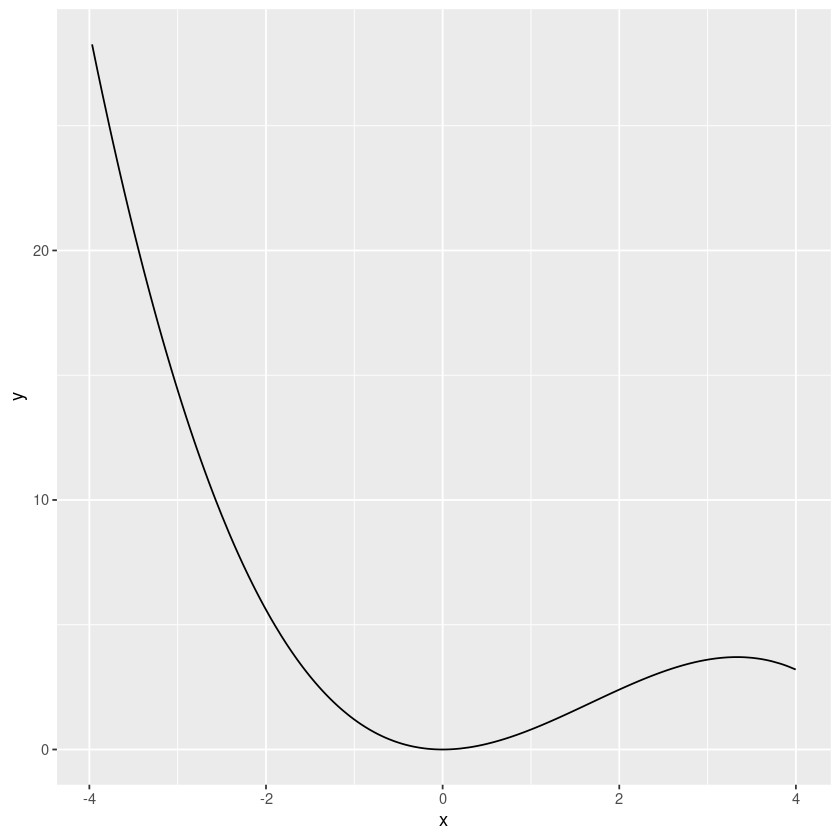

In [2]:
# function to approximate

x <- runif(500, -4, 4)
y <- x^2 - 0.2 * x^3

library(ggplot2)
ggplot(data.frame(x = x, y = y), aes(x, y)) +
    geom_line()

We can specify the model by generating two layers rather than one in a keras sequential model.  Note the pipe notation highlights how a network is built layer-by-layer.

In [3]:
model <- keras_model_sequential() %>%
    layer_dense(2, activation = "sigmoid", input_shape = 1) %>%
    layer_dense(1) # if no activiation is specified, default to linear

model %>% compile(
    optimizer = "rmsprop",
    loss = "mse", # mean squared error
    metrics = "mae" # mean absolute error
)

As we begin to build more complex models, keeping track of their structure becomes important.

In [ ]:
summary(model)

As above, we can now fit the model.

In [4]:
history <- model %>% fit(x, y, epochs = 1000, batch_size = 50)
plot(history)

We can also visualize how well our function approximation compares with the truth.

In [ ]:
# generate predicted values from fitted model
y_hat <- as.numeric(predict(model, x))

# plot true and estimated function
data_plot <- data.frame(
    x = rep(x, 2),
    y = c(y, y_hat),
    type = c(rep("true", length(x)), rep("fitted", length(x)))
)

ggplot(data_plot, aes(x = x, y = y, col = type)) + geom_line()

To obtain a better approximation, we can increase the number of nodes in the network.  Let's try 20 nodes for a much more flexible model.

In [ ]:
model <- keras_model_sequential() %>%
    layer_dense(20, activation = "sigmoid", input_shape = 1) %>%
    layer_dense(1) # if no activiation is specified, default to linear

model %>% compile(
    optimizer = "rmsprop",
    loss = "mse", # mean squared error
    metrics = "mae" # mean absolute error
)

In [ ]:
summary(model)

In [ ]:
history <- model %>% fit(x, y, epochs = 1000, batch_size = 50)
plot(history)

In [ ]:
# generate predicted values from fitted model
y_hat <- as.numeric(predict(model, x))

# plot true and estimated function
data_plot <- data.frame(
    x = rep(x, 2),
    y = c(y, y_hat),
    type = c(rep("true", length(x)), rep("fitted", length(x)))
)

ggplot(data_plot, aes(x = x, y = y, col = type)) +
    geom_line()

# Out-of-Sample Performance

Recall the out-of-sample goodness-of-fit comparison we did with regression trees.  We can perform a similar excercise with a neural network:

In [ ]:
set.seed(20)
train <- sample(1:nrow(data), 2000)

covars <- c("log_pop", "white_share", "log_y", "south", "un_rate")

x_train <- as.matrix(data[train, covars])
y_train <- as.matrix(data[train, "trump_win"])

x_test <- as.matrix(data[-train, covars])
y_test <- as.matrix(data[-train, "trump_win"])

In [ ]:
# instantiate keras model for logistic regression
model <- keras_model_sequential() %>%
    layer_dense(10, activation = "relu", input_shape = 5) %>%
    layer_dense(10, activation = "relu") %>%
    layer_dense(1, activation = "sigmoid")

# compile model (in place)
model %>% compile(
    optimizer = "rmsprop",
    loss = "binary_crossentropy",
    metrics = "accuracy"
)

In [ ]:
history <- model %>% fit(x_train, y_train, epochs = 400, batch_size = 50)
model %>% evaluate(x_test, y_test) # assess out-of-sample goodness-of-fit